# Extracting for a single year

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/2457952090.py:45: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55708 39.76147, -75.55706 39.761...                 22307   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 21782   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 19542   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 20375   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 22135   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 21705   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 22282   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 24218   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 30537   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 21510   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 22401   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

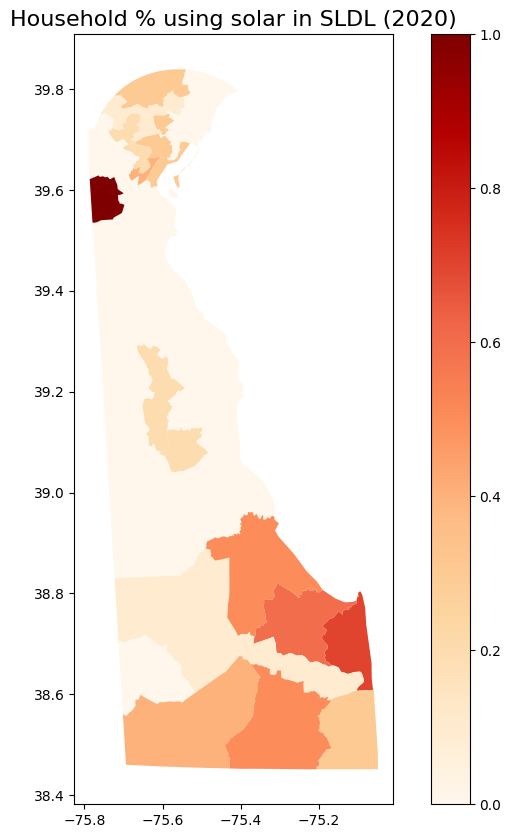

In [1]:
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

year = '2020'

usr_key = os.environ.get('CENSUS_API_KEY')

host = 'https://api.census.gov/data'
dataset_acronym = '/acs/acs5'
g = '?get='
variables = 'NAME,B01001_001E,B25040_001E,B25040_008E'
location = '&for=state%20legislative%20district%20(lower%20chamber):*&in=state:10'

# Put it all together in one f-string:
query_url = f"{host}/{year}{dataset_acronym}{g}{variables}{location}&key={usr_key}"

response = requests.get(query_url)

# Create shapefile query URL
shape_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/SLDL/tl_{year}_10_sldl.zip"

# Read the shapefile from the URL into a GeoPandas DataFrame
sldu_gdf = gpd.read_file(shape_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    
    # Convert the JSON response to a list of lists (excluding the header)
    data = response.json()[1:]
    
    # Convert the list of lists into a DataFrame
    columns = response.json()[0]  # Use the first row as column names
    api_data_df = pd.DataFrame(data, columns=columns)
    api_data_df = api_data_df.astype({'B25040_001E':'int64','B25040_008E':'int64'}) #.apply(pd.to_numeric, errors='ignore')
    api_data_df['Percentage of households using solar energy'] = round((api_data_df['B25040_008E'] / api_data_df['B25040_001E']) * 100, 1)
#     print(api_data_df.head())
    
    # Spatial intersection to retain only the parts within the dry land of Delaware
    delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')
    
    # Dissolve the GeoDataFrame based on the SLDUST column to eliminate duplicates
    delaware_land_gdf_dissolved = delaware_land_gdf.dissolve(by='SLDLST', aggfunc='first')
    
    # Merge the DataFrame with the GeoDataFrame based on the common key
    output_gdf = delaware_land_gdf_dissolved.merge(api_data_df, left_on="SLDLST", right_on="state legislative district (lower chamber)")
    output_gdf = output_gdf[['geometry','B01001_001E','Percentage of households using solar energy','state legislative district (lower chamber)']]
    output_gdf.rename(columns={'B01001_001E':'Estimated Population','state legislative district (lower chamber)':'District'},inplace=True)
    output_gdf = output_gdf.apply(pd.to_numeric, errors='ignore')
    print(output_gdf)
    
    # Save the merged GeoDataFrame as a GeoJSON file
    output_file = f"./DSHA_SLDL_all_years/SLDL_{year}.json"
    output_gdf.to_file(output_file, driver='GeoJSON')
    
    # Plot the merged GeoDataFrame with the added information from the DataFrame
    fig, ax = plt.subplots(figsize=(10, 10))
    output_gdf.plot(column="Percentage of households using solar energy", cmap="OrRd", legend=True, ax=ax)
    ax.set_title(f"Household % using solar in SLDL ({year})", fontsize=16)
else:
    print("Error: Unable to fetch data from the API.")

plt.savefig(f"./DSHA_SLDL_all_years/sldl_{year}.png", dpi=300)


In [2]:
output_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   geometry                                     41 non-null     geometry
 1   Estimated Population                         41 non-null     int64   
 2   Percentage of households using solar energy  41 non-null     float64 
 3   District                                     41 non-null     int64   
dtypes: float64(1), geometry(1), int64(2)
memory usage: 1.4 KB


# Extracting for a range of years

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55714 39.76163, -75.55692 39.761...                 22027   
1   POLYGON ((-75.49132 39.71034, -75.49130 39.710...                 20772   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 21361   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 22096   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 22179   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 21468   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 21204   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 23995   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 23347   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 22449   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 20918   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55714 39.76163, -75.55692 39.761...                 22799   
1   POLYGON ((-75.49132 39.71034, -75.49130 39.710...                 20967   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 21168   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 21915   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 22313   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 22059   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 21643   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 23925   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 24466   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 22148   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 20513   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55714 39.76163, -75.55692 39.761...                 22322   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 21025   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 21271   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 22002   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 22993   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 22719   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 21694   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 23526   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 25309   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 22037   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 20475   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55714 39.76163, -75.55692 39.761...                 22303   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 21172   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 20525   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 22039   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 23678   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 22587   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 22072   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 23916   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 25295   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 22042   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 20905   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55714 39.76163, -75.55692 39.761...                 22505   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 21348   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 19408   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 22319   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 23761   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 22716   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 21789   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 24401   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 26872   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 21946   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 21237   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55714 39.76163, -75.55692 39.761...                 21743   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 21794   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 19015   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 21938   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 22377   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 23208   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 22384   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 24369   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 28661   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 22145   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 21592   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55708 39.76147, -75.55706 39.761...                 22307   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 21782   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 19542   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 20375   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 22135   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 21705   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 22282   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 24218   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 30537   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 21510   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 22401   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_82979/100272011.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.55708 39.76147, -75.55706 39.761...                 22262   
1   POLYGON ((-75.49140 39.71055, -75.49136 39.710...                 22198   
2   POLYGON ((-75.58837 39.75310, -75.58833 39.753...                 19796   
3   POLYGON ((-75.66381 39.77090, -75.66338 39.770...                 21154   
4   POLYGON ((-75.68708 39.62836, -75.68701 39.628...                 21808   
5   POLYGON ((-75.46614 39.75046, -75.46623 39.750...                 21968   
6   POLYGON ((-75.45036 39.77531, -75.45407 39.777...                 22773   
7   POLYGON ((-75.77721 39.53535, -75.77577 39.535...                 24756   
8   MULTIPOLYGON (((-75.75209 39.51066, -75.75203 ...                 32100   
9   POLYGON ((-75.42677 39.78840, -75.43617 39.785...                 22452   
10  POLYGON ((-75.76820 39.41553, -75.76715 39.415...                 22429   
11  POLYGON ((-75.71414 39.79431, -75.71400 39.794..

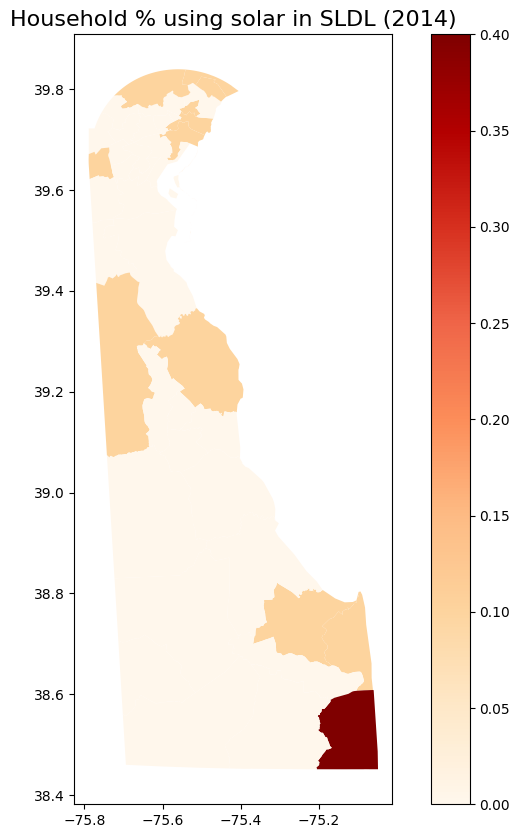

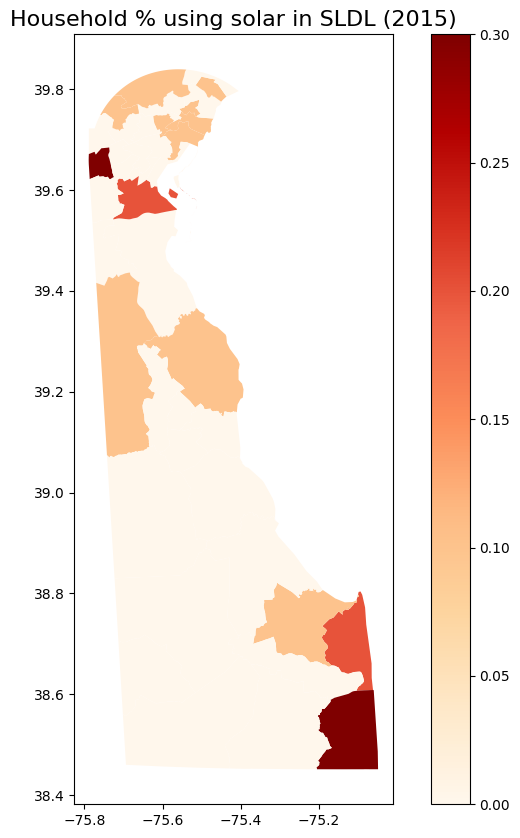

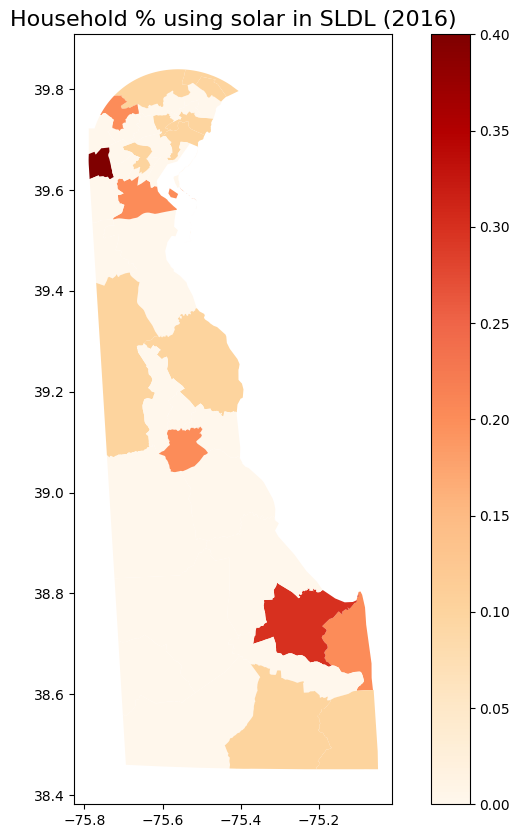

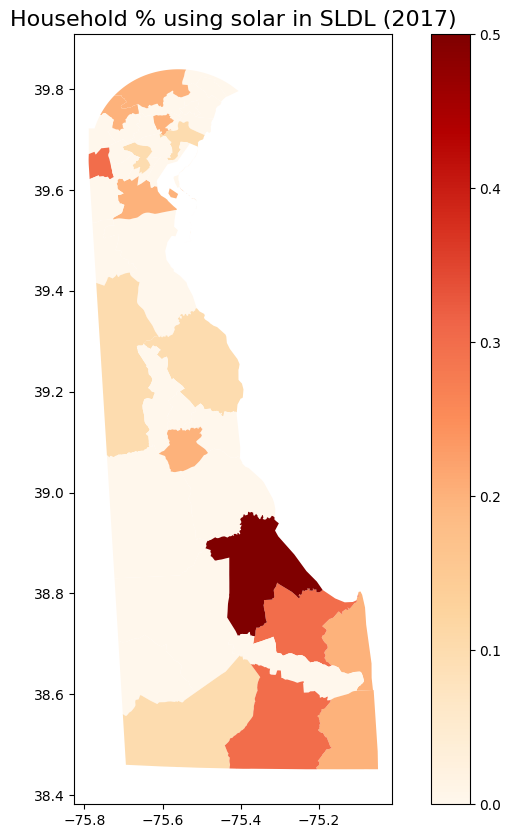

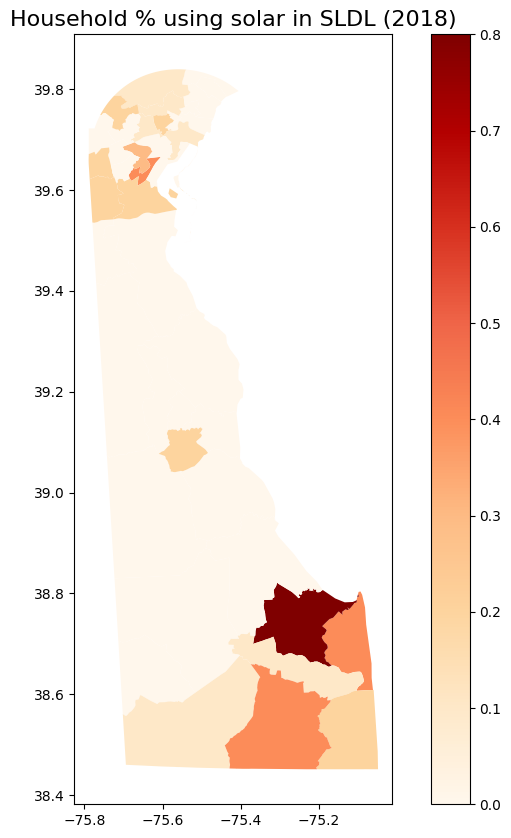

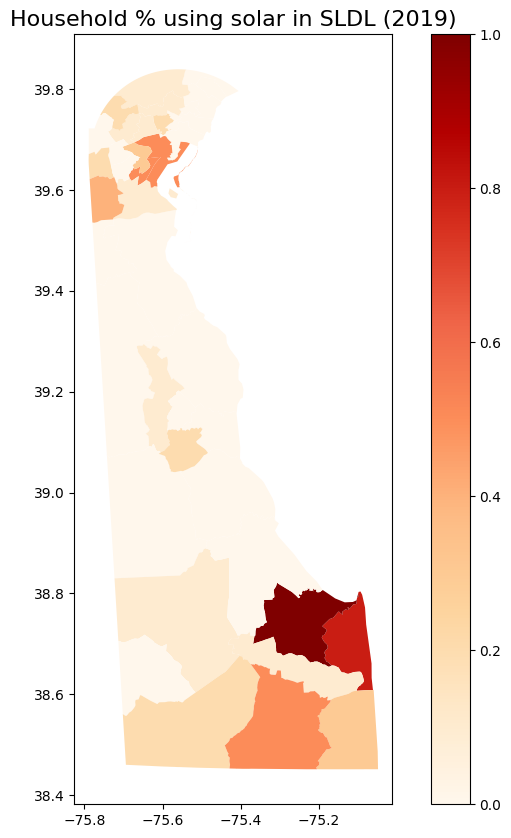

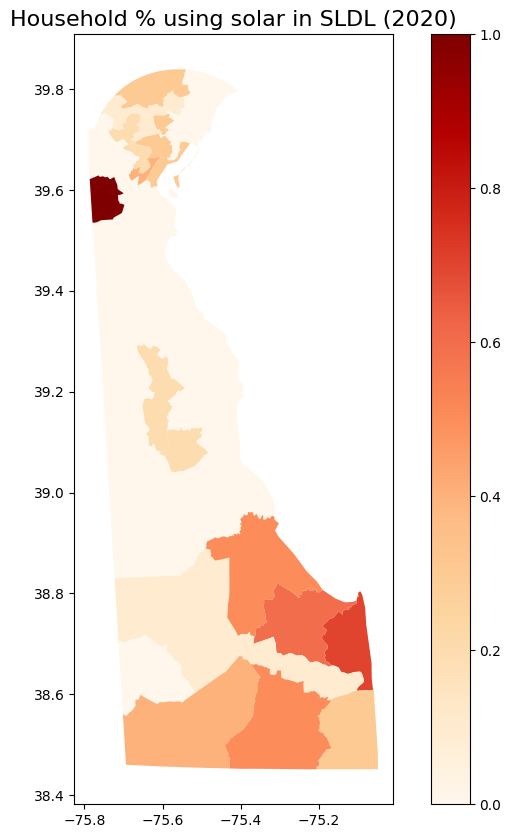

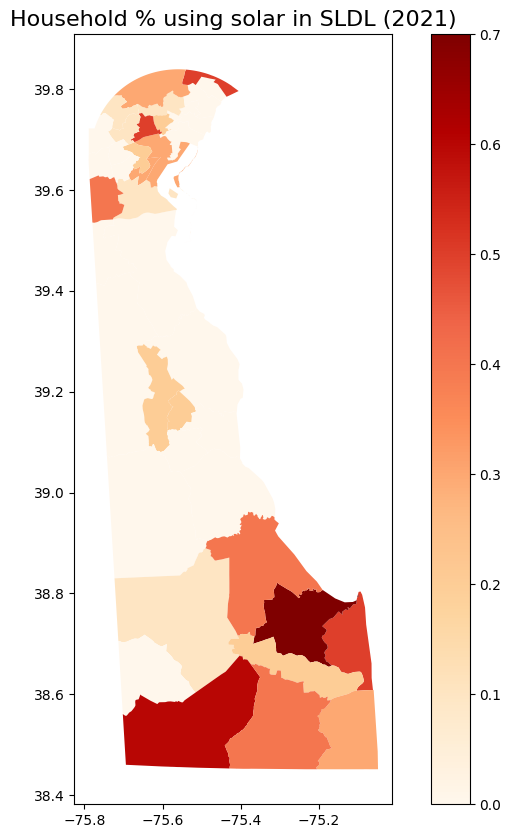

In [3]:
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

usr_key = os.environ.get('CENSUS_API_KEY')

for i in range(2014,2022):
    year = str(i)
    
    host = 'https://api.census.gov/data'
    dataset_acronym = '/acs/acs5'
    g = '?get='
    variables = 'NAME,B01001_001E,B25040_001E,B25040_008E'
    location = '&for=state%20legislative%20district%20(lower%20chamber):*&in=state:10'

    # Put it all together in one f-string:
    query_url = f"{host}/{year}{dataset_acronym}{g}{variables}{location}&key={usr_key}"

    response = requests.get(query_url)

    # Create shapefile query URL
    shape_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/SLDL/tl_{year}_10_sldl.zip"

    # Read the shapefile from the URL into a GeoPandas DataFrame
    sldu_gdf = gpd.read_file(shape_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:

        # Convert the JSON response to a list of lists (excluding the header)
        data = response.json()[1:]

        # Convert the list of lists into a DataFrame
        columns = response.json()[0]  # Use the first row as column names
        api_data_df = pd.DataFrame(data, columns=columns)
        api_data_df = api_data_df.astype({'B25040_001E':'int64','B25040_008E':'int64'}) #.apply(pd.to_numeric, errors='ignore')
        api_data_df['Percentage of households using solar energy'] = round((api_data_df['B25040_008E'] / api_data_df['B25040_001E']) * 100, 1)
#         print(api_data_df.head())

        # Spatial intersection to retain only the parts within the dry land of Delaware
        delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')

        # Dissolve the GeoDataFrame based on the SLDUST column to eliminate duplicates
        delaware_land_gdf_dissolved = delaware_land_gdf.dissolve(by='SLDLST', aggfunc='first')

        # Merge the DataFrame with the GeoDataFrame based on the common key
        output_gdf = delaware_land_gdf_dissolved.merge(api_data_df, left_on="SLDLST", right_on="state legislative district (lower chamber)")
        output_gdf = output_gdf[['geometry','B01001_001E','Percentage of households using solar energy','state legislative district (lower chamber)']]
        output_gdf.rename(columns={'B01001_001E':'Estimated Population','state legislative district (lower chamber)':'District'},inplace=True)
        output_gdf = output_gdf.apply(pd.to_numeric, errors='ignore')
        print(output_gdf)

        # Save the merged GeoDataFrame as a GeoJSON file
        output_file = f"./DSHA_SLDL_all_years/SLDL_{year}.json"
        output_gdf.to_file(output_file, driver='GeoJSON')

        # Plot the merged GeoDataFrame with the added information from the DataFrame
        fig, ax = plt.subplots(figsize=(10, 10))
        output_gdf.plot(column="Percentage of households using solar energy", cmap="OrRd", legend=True, ax=ax)
        ax.set_title(f"Household % using solar in SLDL ({year})", fontsize=16)
    else:
        print("Error: Unable to fetch data from the API.")

    plt.savefig(f"./DSHA_SLDL_all_years/sldl_{year}.png", dpi=300)
